## Classification using AlexNet

In this notebook, a particular configuration of convolutional neural networks called [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) is utilized to train a classifier based on raw images of the BreakHis dataset. First, I divided the images into train and test sets in a patient-wise manner and then I read the corresponding image files. To lower the size of computations, the images are resized to be 230 $\times$ 350. Then, the image data are scaled by subtracting from the mean of the train set and by dividing by the overall maximum value which is 255. Then, using the `keras` library, a slightly modified AlexNet model is introduced which contains 5 convolutional layers and 4 dense layers. In order to address the issue of overfitting, some dropout layers have been added between the dense layers. In total, this model contains more than 32 million trainable parameters. I defined a check point to store the weights of the model whenever the network reaches a peak in terms of accuracy of predicting the labels of the test set. At the end, this best model is called from the disk and the corresponding values of the accuracy and the recognition scores are calculated.

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [2]:
np.random.seed(42)

In [3]:
df = pd.read_csv('./specs.csv')

In [4]:
patients = list(df['Patient_Id'].unique())

In [5]:
train_frac = 0.75

In [6]:
train_size = int(train_frac * len(patients))

In [7]:
train_patients = list(np.random.choice(patients, size = train_size, replace = False))
test_patients = list(set(patients) - set(train_patients)) 

In [8]:
df_train = df.set_index('Patient_Id').loc[train_patients].reset_index()
df_test  = df.set_index('Patient_Id').loc[test_patients].reset_index()

In [37]:
del X_train
del X_test

In [38]:
dst_folder = './Images/'
img_list = []

for index, row in df_train.iterrows():
    file_name = dst_folder + row['Image_Id'] + '.png'
    img_list.append(cv2.resize(cv2.imread(file_name), (0,0), fx=0.5, fy=0.5))

mean_img_train = np.mean(img_list, axis=(0, 1, 2))

X_train = img_list - mean_img_train
    
del img_list

X_train /= 255

In [39]:
dst_folder = './Images/'
img_list = []

for index, row in df_test.iterrows():
    file_name = dst_folder + row['Image_Id'] + '.png'
    img_list.append(cv2.resize(cv2.imread(file_name), (0,0), fx=0.5, fy=0.5))

X_test = img_list - mean_img_train

del img_list

X_test /= 255

In [40]:
y_train = np.array(df_train['Label'])
y_test  = np.array(df_test['Label'])

## CNN Model

In [41]:
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96,
                 input_shape=X_train.shape[1:],
                 kernel_size=11,
                 strides=4,
                 activation='relu'))

# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=256,
                 kernel_size=11,
                 strides=1,
                 activation='relu'))

# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Batch Normalisation
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=384,
                 kernel_size=3,
                 strides=1,
                 activation='relu'))

# Batch Normalisation
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(filters=384,
                 kernel_size=3,
                 strides=1,
                 activation='relu'))

# Batch Normalisation
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(filters=256,
                 kernel_size=3,
                 strides=1,
                 activation='relu'))

# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Batch Normalisation
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(4096, activation='relu'))

# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096, activation='relu'))

# Add Dropout
model.add(Dropout(0.4))

# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000, activation='relu'))

# Add Dropout
model.add(Dropout(0.4))

# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(1, activation='sigmoid'))

In [42]:
# model.summary()

In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
file_name = 'model_alexnet.h5'
earlystopper = EarlyStopping(patience=20, verbose=1)
checkpointer = ModelCheckpoint(file_name, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [45]:
results = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[earlystopper, checkpointer])

Train on 1510 samples, validate on 464 samples
Epoch 1/50
1510/1510 [==============================] - 12s 8ms/step - loss: 0.8566 - acc: 0.7212 - val_loss: 5.4744 - val_acc: 0.5043

Epoch 00001: val_acc improved from -inf to 0.50431, saving model to model_alexnet.h5
Epoch 2/50
1510/1510 [==============================] - 8s 5ms/step - loss: 0.4649 - acc: 0.8073 - val_loss: 1.6836 - val_acc: 0.5603

Epoch 00002: val_acc improved from 0.50431 to 0.56034, saving model to model_alexnet.h5
Epoch 3/50
1510/1510 [==============================] - 8s 5ms/step - loss: 0.4602 - acc: 0.8060 - val_loss: 1.4933 - val_acc: 0.7004

Epoch 00003: val_acc improved from 0.56034 to 0.70043, saving model to model_alexnet.h5
Epoch 4/50
1510/1510 [==============================] - 8s 5ms/step - loss: 0.4812 - acc: 0.8126 - val_loss: 0.8761 - val_acc: 0.7629

Epoch 00004: val_acc improved from 0.70043 to 0.76293, saving model to model_alexnet.h5
Epoch 5/50
1510/1510 [==============================] - 8s 5ms/

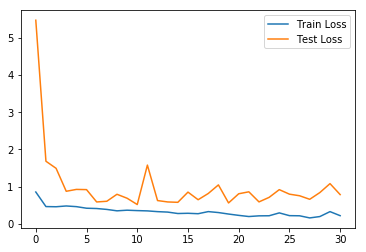

In [46]:
plt.plot(results.history['loss'], label = 'Train Loss')
plt.plot(results.history['val_loss'], label = 'Test Loss')
plt.legend();

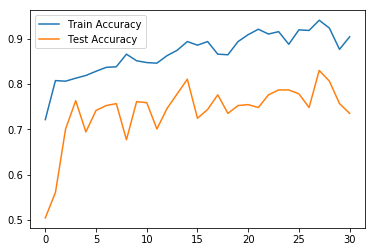

In [47]:
plt.plot(results.history['acc'], label = 'Train Accuracy')
plt.plot(results.history['val_acc'], label = 'Test Accuracy')
plt.legend();

In [48]:
best_model = load_model(file_name)

In [49]:
scores = best_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 82.97%


In [50]:
df_test['pred'] = best_model.predict_classes(X_test)
df_test.head()

,Patient_Id,Image_Id,Tumor_Type,Tumor_Subtype,Magnification,Image_Number,Label,pred,correct
0,6241,SOB_M_DC-14-6241-40-053,M,DC,40,53,1,0,1
1,6241,SOB_M_DC-14-6241-40-051,M,DC,40,51,1,0,0
2,6241,SOB_M_DC-14-6241-40-045,M,DC,40,45,1,1,1
3,6241,SOB_M_DC-14-6241-40-044,M,DC,40,44,1,0,1
4,6241,SOB_M_DC-14-6241-40-054,M,DC,40,54,1,1,1


In [51]:
df_test['correct'] = df_test.apply(lambda x: 1 if x['Label'] == x['pred'] else 0, axis=1)

In [52]:
RC = df_test.groupby('Patient_Id')[['correct']].agg('mean').sum().values[0] / len(df_test.groupby('Patient_Id'))
print('RC = {:0.2%}'.format(RC))

RC = 80.97%
